# breaking down the individual visualizations

In [8]:
# prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
print("Libraries imported!")

# --- INPUT PATHS (edit as needed) ---
orig_path = Path("C:/Users/Steph/local/OIT-class/project-files/datasets/processed/resources_by_hood_with_homeless_camps-csv.csv")  # one row per neighborhood, resource columns
df_orig = pd.read_csv(orig_path, dtype=str, engine="python")

# df = pd.read_csv("resources_by_hood_with_homeless_camps.csv")
df = df_orig.copy()
df.columns = df.columns.str.strip()

# Ensure numeric
for c in ["homeless_camps","number_of_locations","final_resource_calc"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Derived metrics
df["camps_per_location"]      = df["homeless_camps"] / df["number_of_locations"].replace(0, np.nan)
df["resources_per_location"]  = df["final_resource_calc"] / df["number_of_locations"].replace(0, np.nan)
df["resources_per_camp"]      = df["final_resource_calc"] / df["homeless_camps"].replace(0, np.nan)
print("ready to plot!")

Libraries imported!
ready to plot!


Homeless camps by neighborhood.


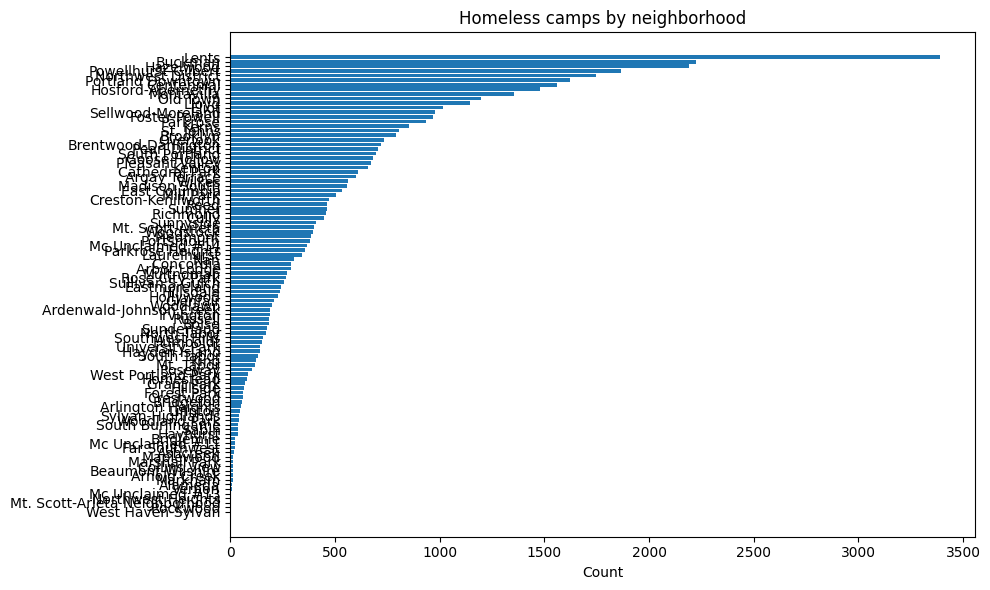

In [9]:
def plot_sorted_bar(series, title, xlabel):
    s = series.sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(s.index, s.values)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

print("Homeless camps by neighborhood.")
plot_sorted_bar(df.set_index("neighborhood")["homeless_camps"], "Homeless camps by neighborhood", "Count")

In [10]:
print("let's see if we can fix the spacing")

def plot_sorted_bar(series, title, xlabel, per_bar_height=0.35, bar_height=0.7, left_margin=0.32):
    s = series.sort_values(ascending=False)
    H = max(6, per_bar_height * len(s))  # figure height scales with #bars
    fig, ax = plt.subplots(figsize=(10, H))

    y = np.arange(len(s))
    ax.barh(y, s.values, height=bar_height)  # smaller height => more spacing between bars
    ax.set_yticks(y, labels=s.index)
    ax.invert_yaxis()

    ax.set_title(title)
    ax.set_xlabel(xlabel)

    # Give y-labels some breathing room
    fig.subplots_adjust(left=left_margin)
    plt.tight_layout()
    plt.show()
print("settings complete")

let's see if we can fix the spacing
settings complete


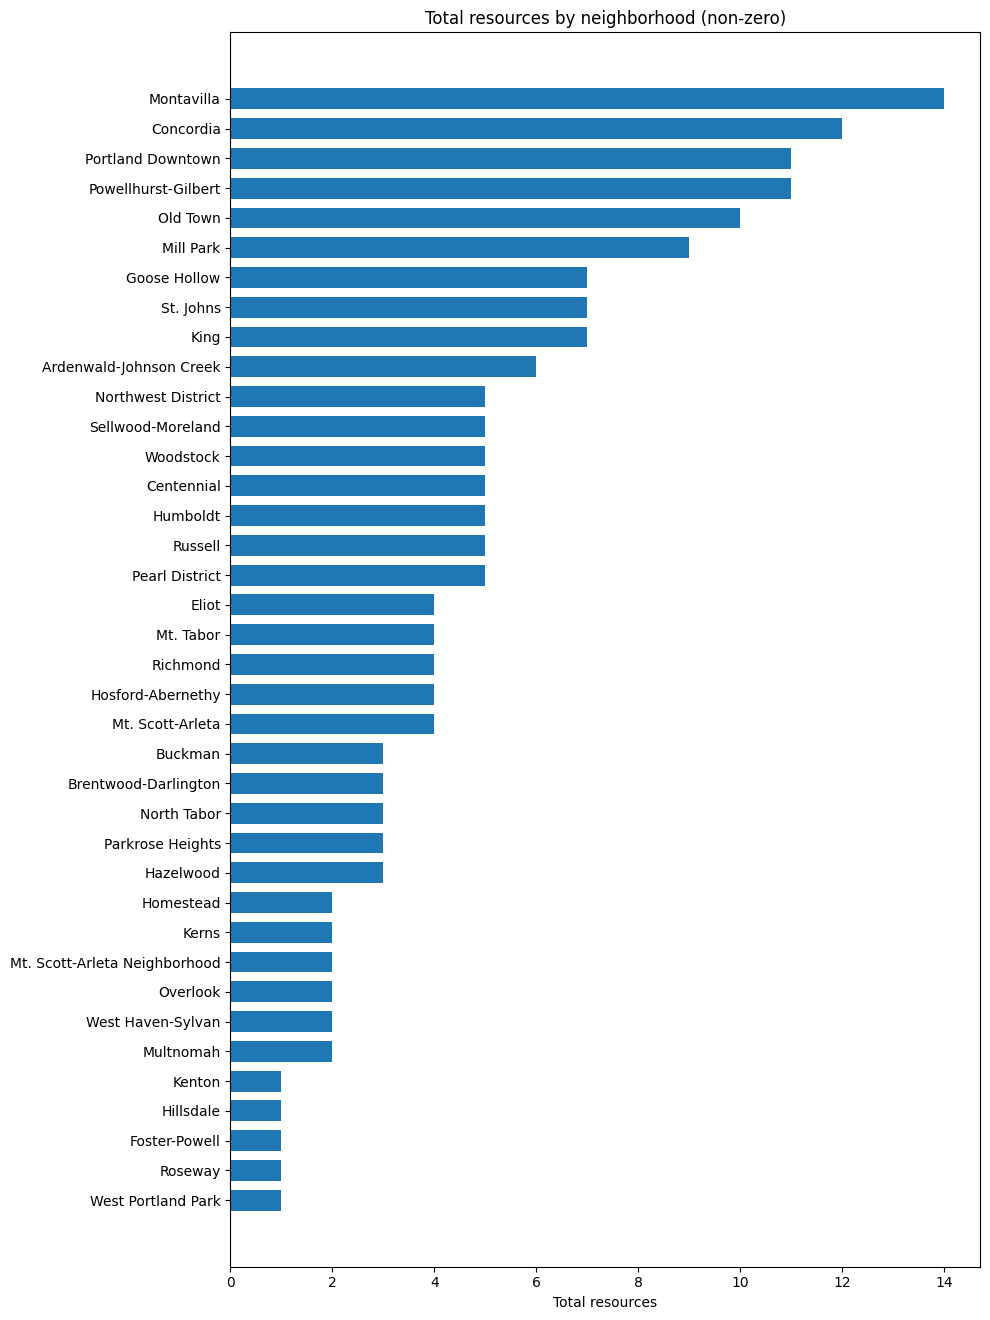

In [13]:
# this tells it to only show neighborhoods with at least one resource
s = df.set_index("neighborhood")["final_resource_calc"]
s = s.fillna(0)           # or s = s.dropna()
s = s[s > 0]              # keep only > 0
plot_sorted_bar(s, "Total resources by neighborhood (non-zero)", "Total resources")


# this plots with all neighborhoods
#plot_sorted_bar(
#    df.set_index("neighborhood")["final_resource_calc"],
#    "Total resources by neighborhood",
#    "Total resources"
#)

Total resources by neighborhood.


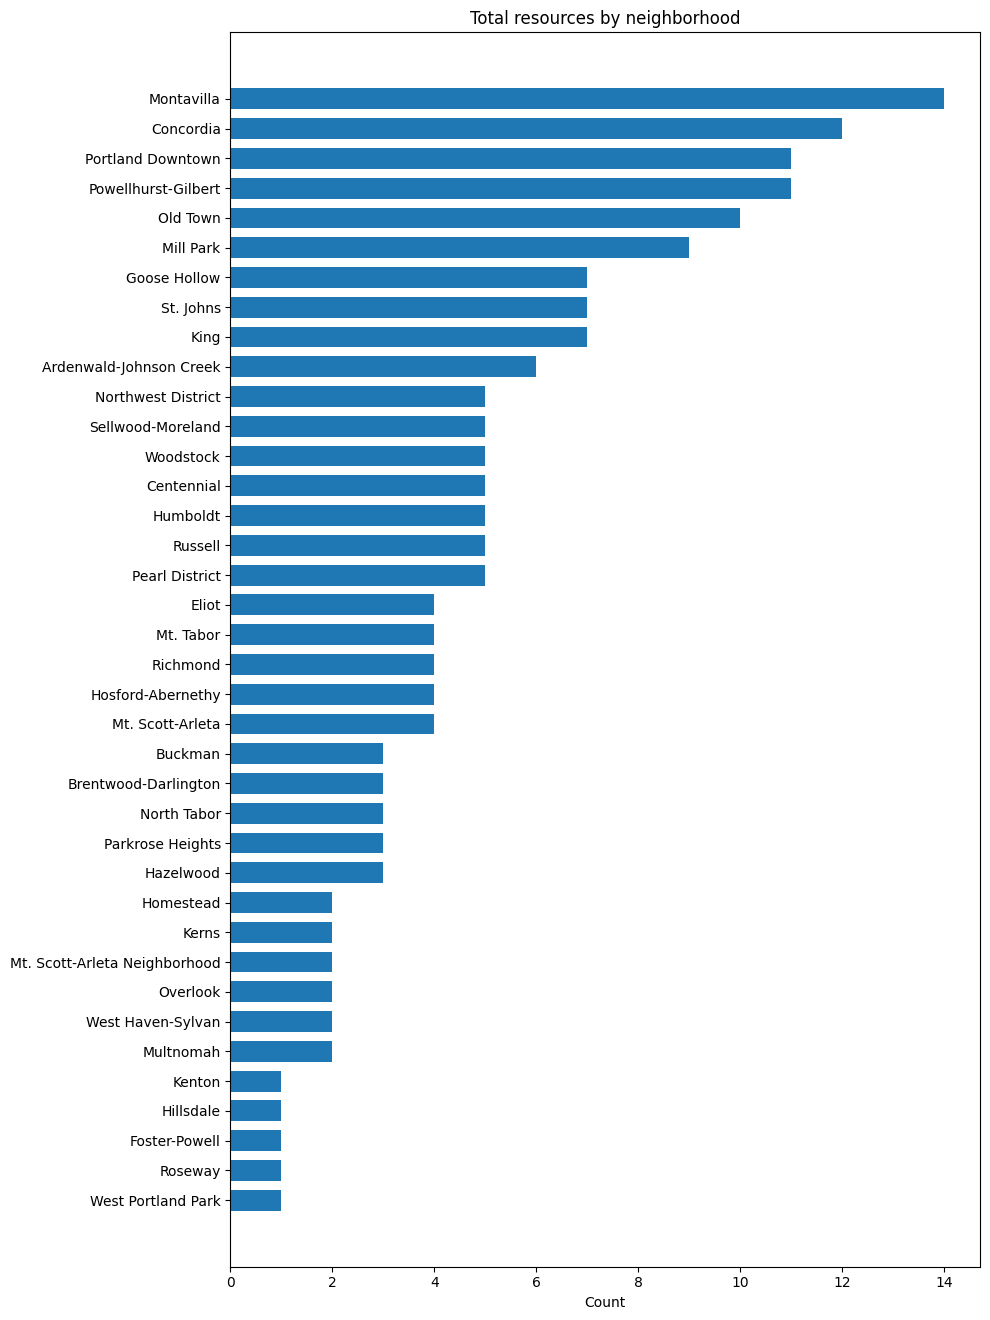

In [16]:
print("Total resources by neighborhood.")
s = df.set_index("neighborhood")["final_resource_calc"].fillna(0)
plot_sorted_bar(s[s > 0], "Total resources by neighborhood", "Count")


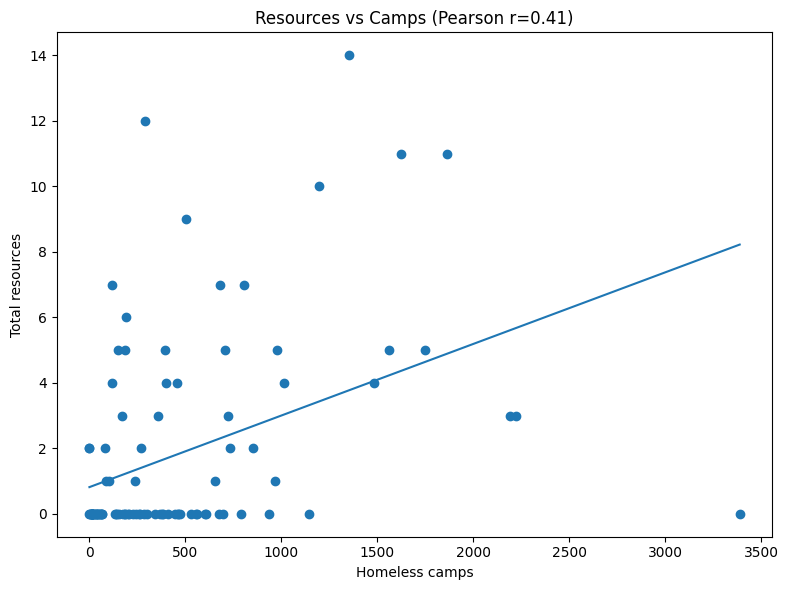

In [17]:
# ---------- 3) Scatter: camps vs resources (+ fit) ----------
x = df["homeless_camps"].values
y = df["final_resource_calc"].values
mask = ~(np.isnan(x) | np.isnan(y))
xv, yv = x[mask], y[mask]

# Fit line
if len(xv) >= 2:
    m, b = np.polyfit(xv, yv, 1)
    r = np.corrcoef(xv, yv)[0,1]
else:
    m, b, r = 0, 0, np.nan

plt.figure(figsize=(8, 6))
plt.scatter(df["homeless_camps"], df["final_resource_calc"])
if not np.isnan(r):
    xs = np.linspace(df["homeless_camps"].min(), df["homeless_camps"].max(), 100)
    plt.plot(xs, m*xs + b)
    plt.title(f"Resources vs Camps (Pearson r={r:.2f})")
else:
    plt.title("Resources vs Camps")
plt.xlabel("Homeless camps")
plt.ylabel("Total resources")
plt.tight_layout()
plt.show()

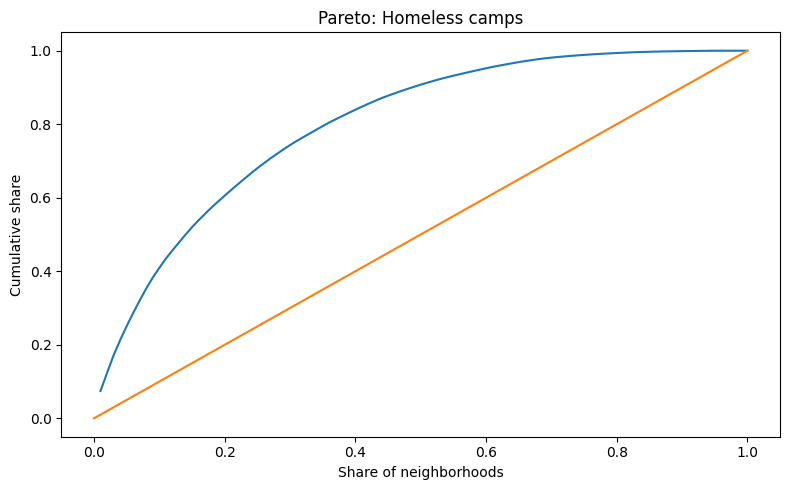

C:\Users\steph\AppData\Local\Temp\ipykernel_42876\3926595694.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz, x2)


Gini for Homeless camps: 0.597


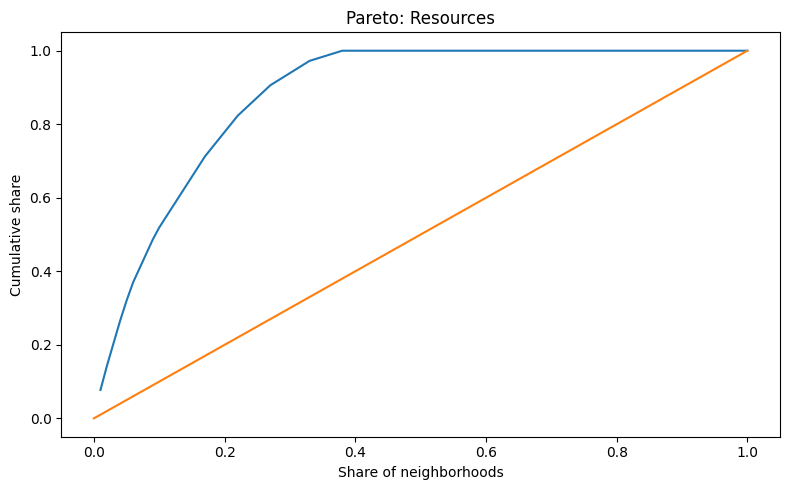

Gini for Resources: 0.760


In [18]:
# ---------- 4) Pareto curve & Gini ----------
def pareto_and_gini(series, title):
    s = series.sort_values(ascending=False).values
    cum = np.cumsum(s)
    cum_share = cum / cum[-1] if cum[-1] > 0 else cum
    x = np.arange(1, len(s)+1) / len(s)
    # Pareto plot
    plt.figure(figsize=(8, 5))
    plt.plot(x, cum_share)
    plt.plot([0,1],[0,1])  # equality line
    plt.title(f"Pareto: {title}")
    plt.xlabel("Share of neighborhoods")
    plt.ylabel("Cumulative share")
    plt.tight_layout()
    plt.show()
    # Gini
    # Gini = 1 - 2 * area under Lorenz curve
    lorenz = np.insert(np.cumsum(np.sort(series.values)), 0, 0)
    lorenz = lorenz / lorenz[-1] if lorenz[-1] > 0 else lorenz
    x2 = np.linspace(0, 1, len(lorenz))
    gini = 1 - 2 * np.trapz(lorenz, x2)
    print(f"Gini for {title}: {gini:.3f}")

pareto_and_gini(df.set_index("neighborhood")["homeless_camps"], "Homeless camps")
pareto_and_gini(df.set_index("neighborhood")["final_resource_calc"], "Resources")

In [20]:
# more info suggested by the robots
def pareto_stats(series, title, cutoffs=(0.1, 0.2, 0.5)):
    s = series.sort_values(ascending=False).values
    if s.sum() == 0:
        print(f"{title}: total is 0; Pareto stats not meaningful.")
        return
    cum = np.cumsum(s) / s.sum()
    n = len(s)
    print(f"\nPareto stats for {title}:")
    for p in cutoffs:
        k = max(1, int(round(p * n)))
        share = cum[k-1]
        print(f"Top {int(p*100)}% of neighborhoods = {share:.1%} of total")

def pareto_and_gini_with_marks(series, title):
    s = series.sort_values(ascending=False).values
    total = s.sum()
    if total == 0:
        print(f"{title}: total is 0")
        return
    cum = np.cumsum(s) / total
    x = np.arange(1, len(s)+1) / len(s)

    plt.figure(figsize=(8,5))
    plt.plot(x, cum, label=title)
    plt.plot([0,1],[0,1], linestyle="--")  # equality line

    # annotate the “80/20” point
    p = 0.2
    k = max(1, int(round(p * len(s))))
    plt.scatter([p], [cum[k-1]])
    plt.annotate(f"Top 20% ⇒ {cum[k-1]:.0%}",
                 xy=(p, cum[k-1]), xytext=(p+0.05, cum[k-1]-0.1),
                 arrowprops=dict(arrowstyle="->"))

    plt.title(f"Pareto: {title}")
    plt.xlabel("Share of neighborhoods (top to bottom)")
    plt.ylabel("Cumulative share")
    plt.tight_layout()
    plt.show()

    # Gini (using Lorenz convention)
    lorenz = np.insert(np.cumsum(np.sort(series.values)), 0, 0)
    lorenz = lorenz / lorenz[-1]
    x2 = np.linspace(0, 1, len(lorenz))
    gini = 1 - 2 * np.trapz(lorenz, x2)
    print(f"Gini for {title}: {gini:.3f}")

    pareto_stats(series, title)


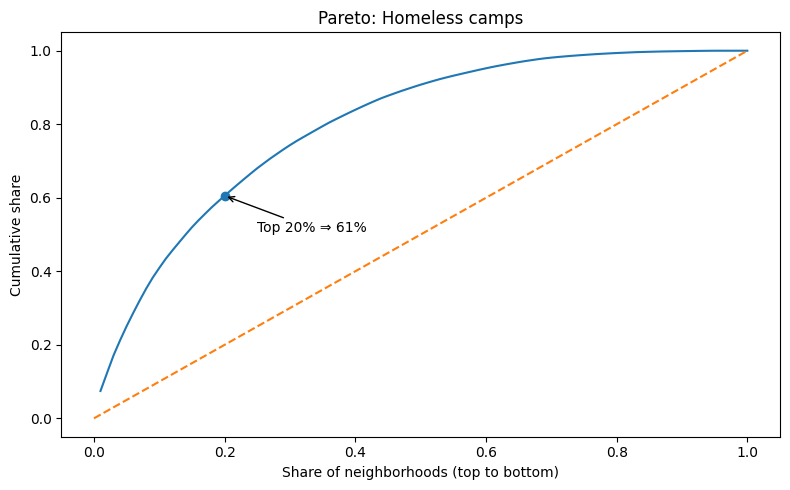

C:\Users\steph\AppData\Local\Temp\ipykernel_42876\2422440616.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz, x2)


Gini for Homeless camps: 0.597

Pareto stats for Homeless camps:
Top 10% of neighborhoods = 40.9% of total
Top 20% of neighborhoods = 60.6% of total
Top 50% of neighborhoods = 90.8% of total


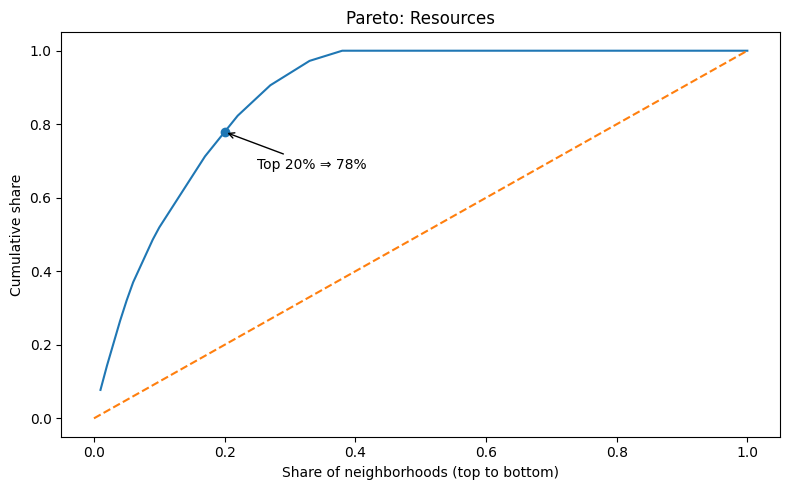

Gini for Resources: 0.760

Pareto stats for Resources:
Top 10% of neighborhoods = 51.9% of total
Top 20% of neighborhoods = 77.9% of total
Top 50% of neighborhoods = 100.0% of total


In [21]:
pareto_and_gini_with_marks(df.set_index("neighborhood")["homeless_camps"], "Homeless camps")
pareto_and_gini_with_marks(df.set_index("neighborhood")["final_resource_calc"], "Resources")


What the “Pareto” plot shows
X-axis: share of neighborhoods (from the top performers down).

Y-axis: cumulative share of the total (camps or resources) contributed by those top neighborhoods.

Equality line (y = x): everyone contributes equally (e.g., 20% of neighborhoods provide 20% of resources).

Because you sort descending, a steep early rise (the curve sits above the line) means concentration: a small set of neighborhoods accounts for a big chunk.
Example reading: if at x = 0.20 the curve is at y = 0.60, that means the top 20% of neighborhoods hold 60% of the total.

If you plot this for:

Homeless camps: how concentrated reports are across neighborhoods.

Resources: how concentrated your resources are.
Comparing curves: if the resources curve climbs faster than the camps curve, resources are more concentrated than need (and vice-versa).

What the Gini number means
0.00 = perfectly even.

1.00 = all in one neighborhood.

Rough feel: 0.0–0.2 low, 0.2–0.4 moderate, 0.4–0.6 high, >0.6 very high concentration.

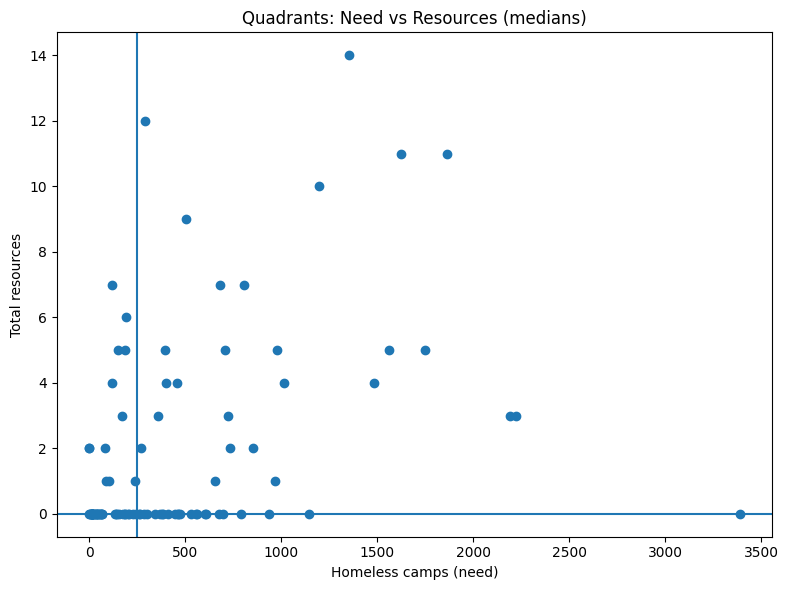

In [22]:
# ---------- 5) Quadrant chart (medians) ----------
med_camps = df["homeless_camps"].median()
med_resources = df["final_resource_calc"].median()

plt.figure(figsize=(8, 6))
plt.scatter(df["homeless_camps"], df["final_resource_calc"])
plt.axvline(med_camps)
plt.axhline(med_resources)
plt.title("Quadrants: Need vs Resources (medians)")
plt.xlabel("Homeless camps (need)")
plt.ylabel("Total resources")
plt.tight_layout()
plt.show()

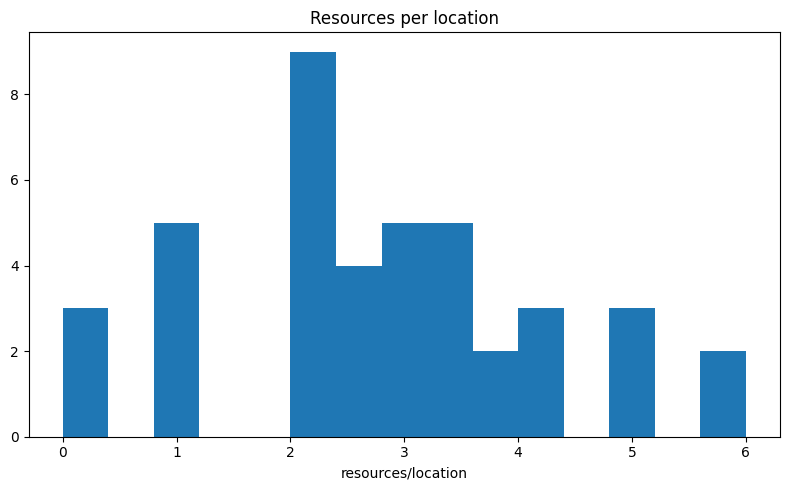

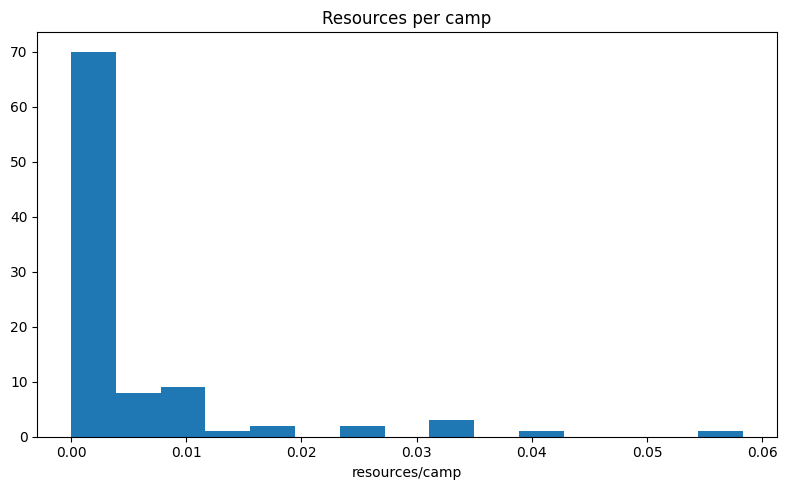

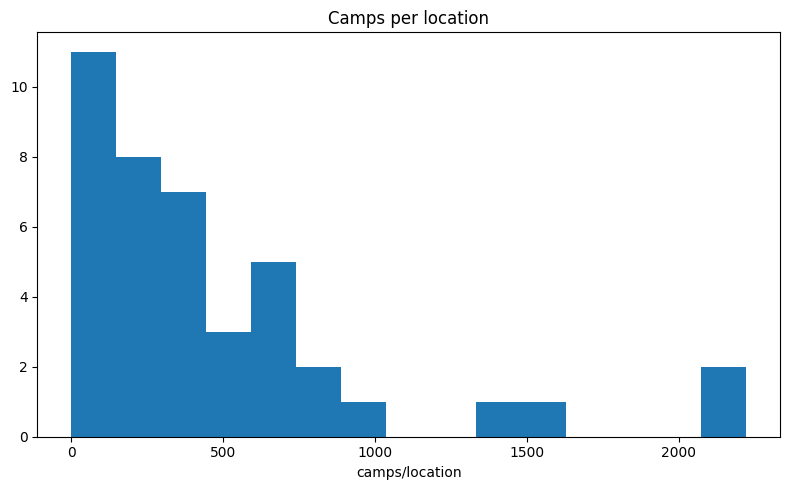

In [31]:
# ---------- 6) Rates distributions ----------
def plot_hist(series, title, xlabel):
    vals = series.replace([np.inf, -np.inf], np.nan).dropna()
    plt.figure(figsize=(8,5))
    plt.hist(vals, bins=15)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

plot_hist(df["resources_per_location"], "Resources per location", "resources/location")
plot_hist(df["resources_per_camp"], "Resources per camp", "resources/camp")
plot_hist(df["camps_per_location"], "Camps per location", "camps/location")

seeing if we can add labels to location


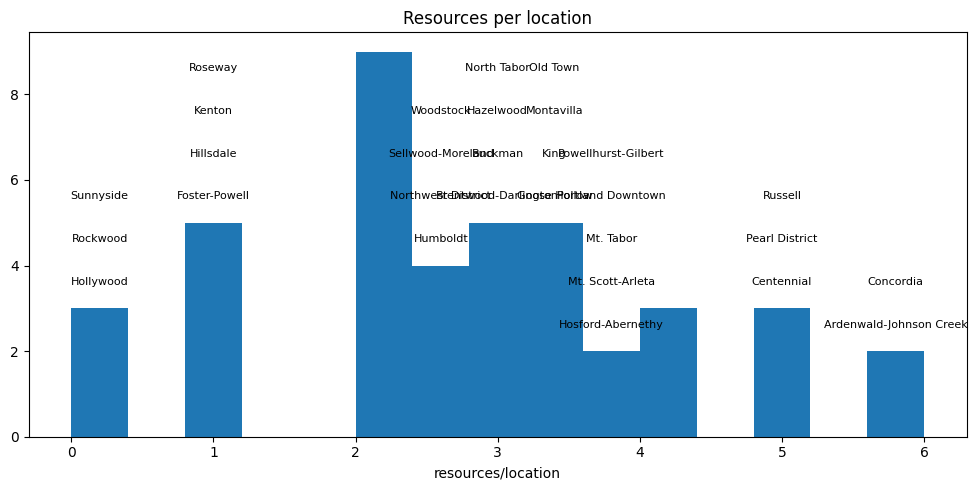

done!


In [39]:
print("seeing if we can add labels to location")

#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
from collections import defaultdict

def plot_hist_with_stacked_labels(series, title, xlabel, bins=15, max_labels_per_bin=6, label_fontsize=8, show_rug=False):
    """
    series: Pandas Series indexed by neighborhood (index = names, values = metric)
    Stacks neighborhood labels above each histogram bar (bin).
    """
    # Clean
    s = pd.to_numeric(series, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        print(f"{title}: nothing to plot.")
        return

    fig, ax = plt.subplots(figsize=(10, 5))
    counts, edges, _ = ax.hist(s.values, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)

    # Optional rug
    if show_rug:
        ymin, ymax = ax.get_ylim()
        rug_h = ymax * 0.05
        for x in s.values:
            ax.vlines(x, 0, rug_h)

    # Map each point to a bin
    bin_idx = np.digitize(s.values, edges, right=True) - 1
    bin_idx = np.clip(bin_idx, 0, len(edges) - 2)  # keep in range
    names = s.index.astype(str).to_numpy()

    by_bin = defaultdict(list)
    for i, b in enumerate(bin_idx):
        by_bin[b].append(names[i])

    # Stack labels per bin at the bar center
    ymin, ymax = ax.get_ylim()
    step = max(1, int(np.ceil(max(counts) * 0.03)))  # vertical step in count units
    for b, name_list in by_bin.items():
        if counts[b] == 0:
            continue
        x_center = 0.5 * (edges[b] + edges[b + 1])
        base_y = counts[b] + 0.5  # start a smidge above the bar
        # show up to max_labels_per_bin, then "+N more"
        to_show = name_list[:max_labels_per_bin]
        for i, lab in enumerate(to_show):
            ax.annotate(lab, (x_center, base_y + i * step),
                        ha="center", va="bottom", fontsize=label_fontsize)
        if len(name_list) > max_labels_per_bin:
            extra = len(name_list) - max_labels_per_bin
            ax.annotate(f"+{extra} more", (x_center, base_y + len(to_show) * step),
                        ha="center", va="bottom", fontsize=label_fontsize)

    plt.tight_layout()
    plt.show()

# Usage with your three series (index by neighborhood):
plot_hist_with_stacked_labels(
    df.set_index("neighborhood")["resources_per_location"],
    "Resources per location", "resources/location", bins=15, max_labels_per_bin=6
)
plot_hist_with_stacked_labels



print("done!")    


In [42]:
# let's try that again
# If df already exists in memory, start here:
df = df.copy()
df.columns = df.columns.str.strip()
df["neighborhood"] = df["neighborhood"].astype("string").str.strip()

print("data gotten!")

# Ensure numeric and build derived metrics (only if missing)
num_cols = ["homeless_camps", "number_of_locations", "final_resource_calc"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

if "resources_per_location" not in df.columns:
    df["resources_per_location"] = df["final_resource_calc"] / df["number_of_locations"].replace(0, np.nan)
if "resources_per_camp" not in df.columns:
    df["resources_per_camp"] = df["final_resource_calc"] / df["homeless_camps"].replace(0, np.nan)
if "camps_per_location" not in df.columns:
    df["camps_per_location"] = df["homeless_camps"] / df["number_of_locations"].replace(0, np.nan)

# ---- Function: histogram + stacked labels per bin ----
from collections import defaultdict

def plot_hist_with_stacked_labels(series, title, xlabel, bins=15, max_labels_per_bin=6, label_fontsize=8, show_rug=False):
    """
    series: Pandas Series indexed by neighborhood (index = names, values = metric)
    Stacks neighborhood labels above each histogram bar (bin).
    """
    s = pd.to_numeric(series, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        print(f"{title}: nothing to plot.")
        return

    fig, ax = plt.subplots(figsize=(10, 5))
    counts, edges, patches = ax.hist(s.values, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)

    # Optional rug at the bottom
    if show_rug:
        ymin, ymax = ax.get_ylim()
        rug_h = ymax * 0.05
        for x in s.values:
            ax.vlines(x, 0, rug_h)

    # Map each value to its histogram bin
    bin_idx = np.digitize(s.values, edges, right=True) - 1
    bin_idx = np.clip(bin_idx, 0, len(edges) - 2)
    names = s.index.astype(str).to_numpy()

    by_bin = defaultdict(list)
    for i, b in enumerate(bin_idx):
        by_bin[b].append(names[i])

    # Stack labels above each bar center
    ymin, ymax = ax.get_ylim()
    step = max(1, int(np.ceil(max(counts) * 0.03)))  # vertical step in "count" units
    for b, name_list in by_bin.items():
        if counts[b] == 0:
            continue
        x_center = 0.5 * (edges[b] + edges[b + 1])
        base_y = counts[b] + 0.5  # start just above the bar
        to_show = name_list[:max_labels_per_bin]
        for i, lab in enumerate(to_show):
            ax.annotate(lab, (x_center, base_y + i * step),
                        ha="center", va="bottom", fontsize=label_fontsize)
        if len(name_list) > max_labels_per_bin:
            extra = len(name_list) - max_labels_per_bin
            ax.annotate(f"+{extra} more", (x_center, base_y + len(to_show) * step),
                        ha="center", va="bottom", fontsize=label_fontsize)

    plt.tight_layout()
    plt.show()

print("plot plottened")   

data gotten!
plot plottened


let's try that again!
data gotten!


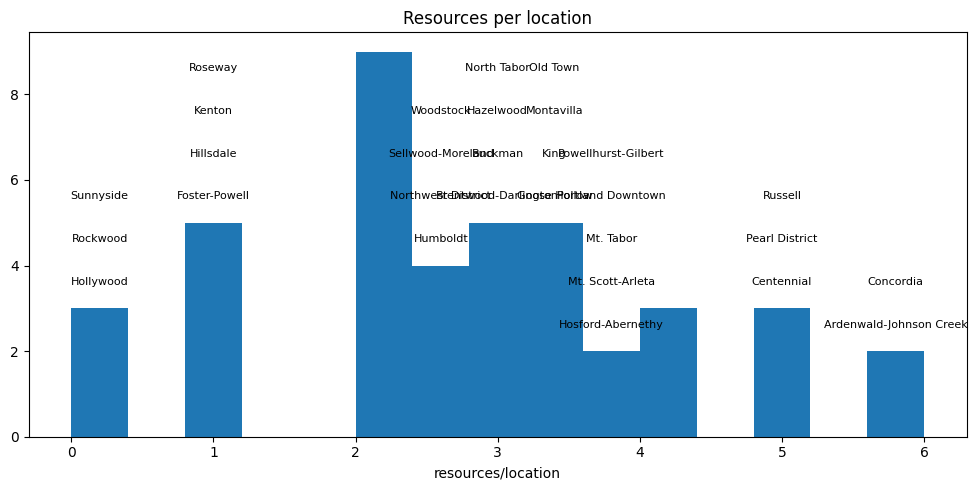

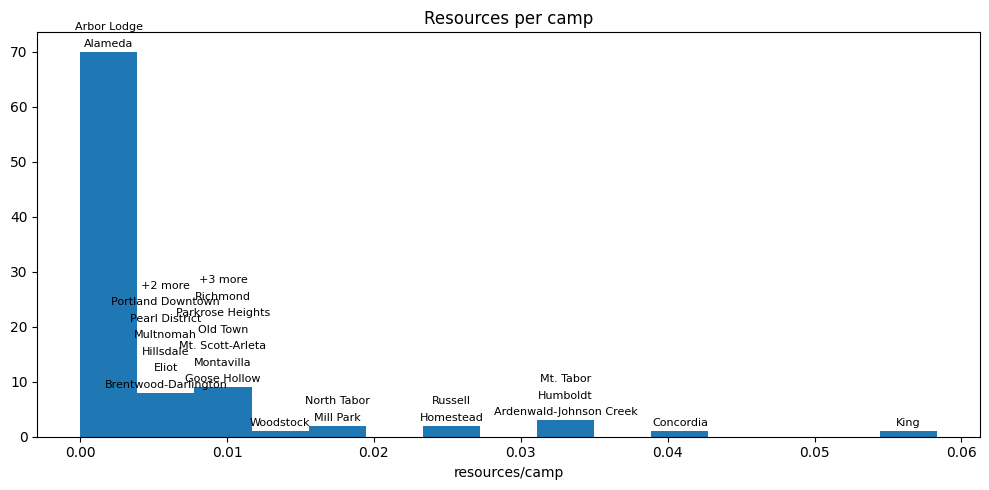

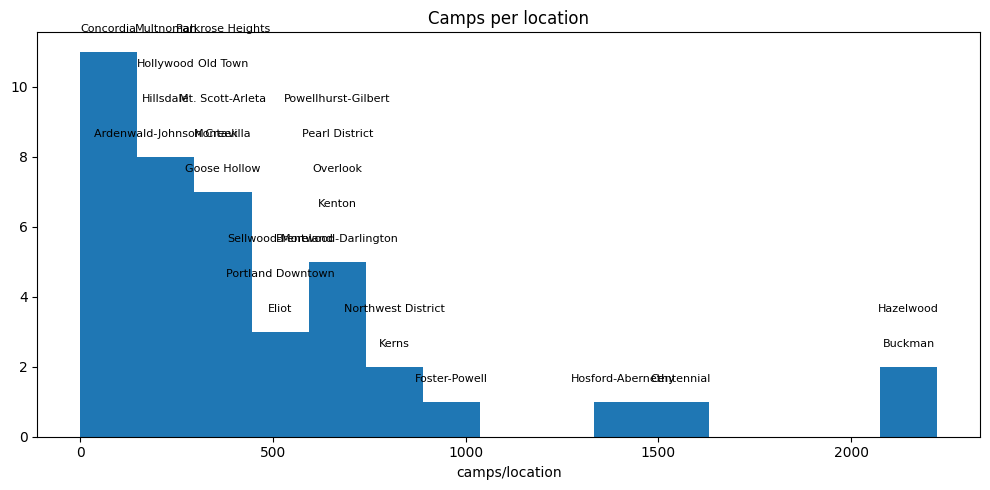

In [43]:
print("let's try that again!")
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt

# If df already exists in memory, start here:
df = df.copy()
df.columns = df.columns.str.strip()
df["neighborhood"] = df["neighborhood"].astype("string").str.strip()

print("data gotten!")

# Ensure numeric + derived metrics
num_cols = ["homeless_camps", "number_of_locations", "final_resource_calc"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

if "resources_per_location" not in df.columns:
    df["resources_per_location"] = df["final_resource_calc"] / df["number_of_locations"].replace(0, np.nan)
if "resources_per_camp" not in df.columns:
    df["resources_per_camp"] = df["final_resource_calc"] / df["homeless_camps"].replace(0, np.nan)
if "camps_per_location" not in df.columns:
    df["camps_per_location"] = df["homeless_camps"] / df["number_of_locations"].replace(0, np.nan)

# ---- Function: histogram + stacked labels per bin ----
from collections import defaultdict

def plot_hist_with_stacked_labels(series, title, xlabel, bins=15, max_labels_per_bin=6, label_fontsize=8, show_rug=False):
    """
    series: Pandas Series indexed by neighborhood (index = names, values = metric)
    Stacks neighborhood labels above each histogram bar (bin).
    """
    s = pd.to_numeric(series, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        print(f"{title}: nothing to plot.")
        return

    fig, ax = plt.subplots(figsize=(10, 5))
    counts, edges, patches = ax.hist(s.values, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)

    # Optional rug at the bottom
    if show_rug:
        ymin, ymax = ax.get_ylim()
        rug_h = ymax * 0.05
        for x in s.values:
            ax.vlines(x, 0, rug_h)

    # Map each value to its histogram bin
    bin_idx = np.digitize(s.values, edges, right=True) - 1
    bin_idx = np.clip(bin_idx, 0, len(edges) - 2)
    names = s.index.astype(str).to_numpy()

    by_bin = defaultdict(list)
    for i, b in enumerate(bin_idx):
        by_bin[b].append(names[i])

    # Stack labels above each bar center
    ymin, ymax = ax.get_ylim()
    step = max(1, int(np.ceil(max(counts) * 0.03)))  # vertical step in "count" units
    for b, name_list in by_bin.items():
        if counts[b] == 0:
            continue
        x_center = 0.5 * (edges[b] + edges[b + 1])
        base_y = counts[b] + 0.5  # start just above the bar
        to_show = name_list[:max_labels_per_bin]
        for i, lab in enumerate(to_show):
            ax.annotate(lab, (x_center, base_y + i * step),
                        ha="center", va="bottom", fontsize=label_fontsize)
        if len(name_list) > max_labels_per_bin:
            extra = len(name_list) - max_labels_per_bin
            ax.annotate(f"+{extra} more", (x_center, base_y + len(to_show) * step),
                        ha="center", va="bottom", fontsize=label_fontsize)

    plt.tight_layout()
    plt.show()

# ---- CALLS (these actually make the plots) ----
plot_hist_with_stacked_labels(
    df.set_index("neighborhood")["resources_per_location"],
    "Resources per location", "resources/location", bins=15, max_labels_per_bin=6
)

plot_hist_with_stacked_labels(
    df.set_index("neighborhood")["resources_per_camp"],
    "Resources per camp", "resources/camp", bins=15, max_labels_per_bin=6
)

plot_hist_with_stacked_labels(
    df.set_index("neighborhood")["camps_per_location"],
    "Camps per location", "camps/location", bins=15, max_labels_per_bin=6
)


In [45]:
# trying to understand these giant numbers
# Inspect the ratio distribution and the biggest cases
s = df.set_index("neighborhood")["camps_per_location"].replace([np.inf,-np.inf], np.nan)
print(s.describe(percentiles=[.5,.9,.95,.99]))

# Show the neighborhoods with the highest ratios
top = (df[["neighborhood","homeless_camps","number_of_locations","camps_per_location"]]
       .replace([np.inf,-np.inf], np.nan)
       .dropna(subset=["camps_per_location"])
       .sort_values("camps_per_location", ascending=False)
       .head(10))
print(top)


count      41.000000
mean      494.361789
std       534.220137
min         0.000000
50%       340.500000
90%       969.000000
95%      1562.000000
99%      2211.000000
max      2223.000000
Name: camps_per_location, dtype: float64
            neighborhood  homeless_camps  number_of_locations  \
13               Buckman            2223                    1   
32             Hazelwood            2193                    1   
15            Centennial            1562                    1   
37     Hosford-Abernethy            1481                    1   
26         Foster-Powell             969                    1   
62    Northwest District            1748                    2   
41                 Kerns             854                    1   
65              Overlook             733                    1   
9   Brentwood-Darlington             721                    1   
68        Pearl District             707                    1   

    camps_per_location  
13              2223.0  
32  

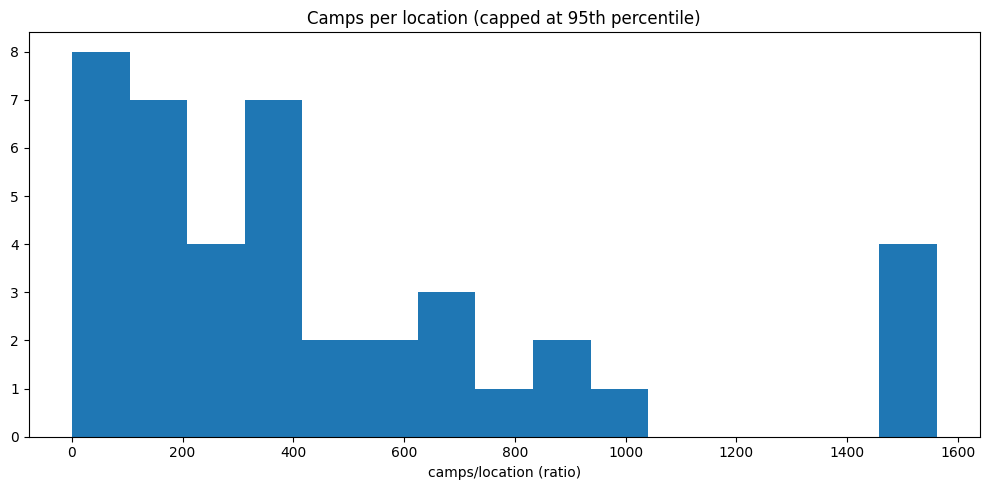

Note: 2 neighborhoods exceed the cap (1562.00).


In [46]:
import numpy as np
import matplotlib.pyplot as plt

vals = s.dropna()
cap = vals.quantile(0.95)
vals_cap = vals.clip(upper=cap)

plt.figure(figsize=(10,5))
plt.hist(vals_cap, bins=15)
plt.title("Camps per location (capped at 95th percentile)")
plt.xlabel("camps/location (ratio)")
plt.tight_layout(); plt.show()

print(f"Note: {(vals > cap).sum()} neighborhoods exceed the cap ({cap:.2f}).")


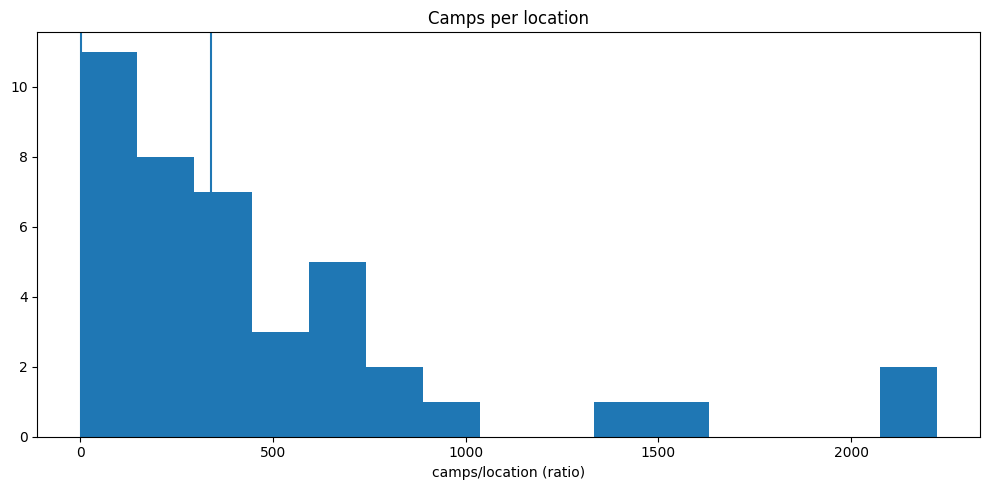

In [44]:
vals = df.set_index("neighborhood")["camps_per_location"].replace([np.inf, -np.inf], np.nan).dropna()
median_val = vals.median()

plt.figure(figsize=(10,5))
plt.hist(vals, bins=15)
plt.axvline(1.0)                 # parity line
plt.axvline(median_val)          # median line
plt.title("Camps per location")
plt.xlabel("camps/location (ratio)")
plt.tight_layout()
plt.show()


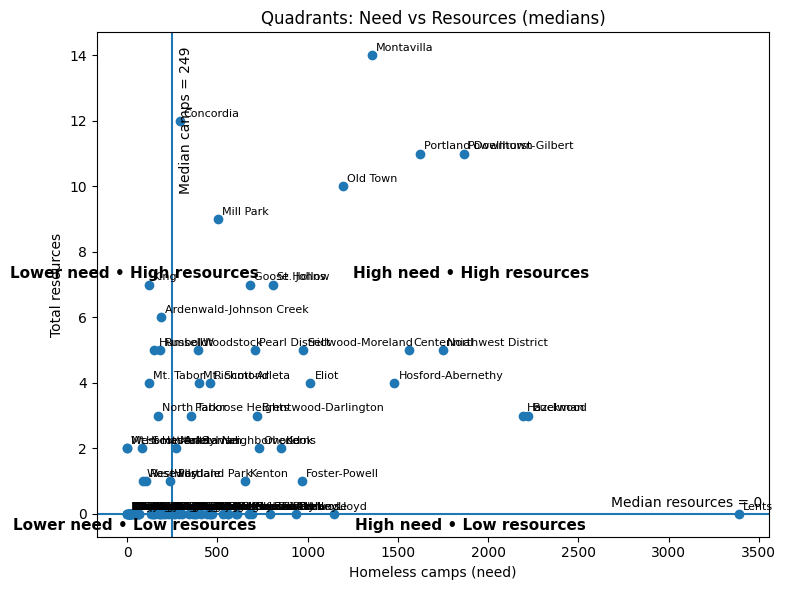

In [30]:

# Medians
med_camps = df["homeless_camps"].median()
med_resources = df["final_resource_calc"].median()

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter
ax.scatter(df["homeless_camps"], df["final_resource_calc"])

# Label every neighborhood (small offset so text isn’t on top of the dot)
for x, y, lab in zip(df["homeless_camps"], df["final_resource_calc"], df["neighborhood"].astype(str)):
    ax.annotate(lab, (x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

# Median lines
ax.axvline(med_camps)
ax.axhline(med_resources)

# Titles/axes
ax.set_title("Quadrants: Need vs Resources (medians)")
ax.set_xlabel("Homeless camps (need)")
ax.set_ylabel("Total resources")

# Get limits (after plotting) to position labels nicely
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()

# Midpoints for each quadrant
x_left  = (x0 + med_camps) / 2
x_right = (med_camps + x1) / 2
y_low   = (y0 + med_resources) / 2
y_high  = (med_resources + y1) / 2

# Quadrant labels
ax.text(x_right, y_high, "High need • High resources", ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_left,  y_high, "Lower need • High resources", ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_right, y_low,  "High need • Low resources",  ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_left,  y_low,  "Lower need • Low resources", ha="center", va="center", fontsize=11, fontweight="bold")

# Annotate median lines with values
ax.annotate(f"Median camps = {med_camps:.0f}",
            xy=(med_camps, y1), xytext=(5, -10),
            textcoords="offset points", va="top", rotation=90)

ax.annotate(f"Median resources = {med_resources:.0f}",
            xy=(x1, med_resources), xytext=(-5, 5),
            textcoords="offset points", ha="right")

plt.tight_layout()
plt.show()



adding some additional labels for clarity


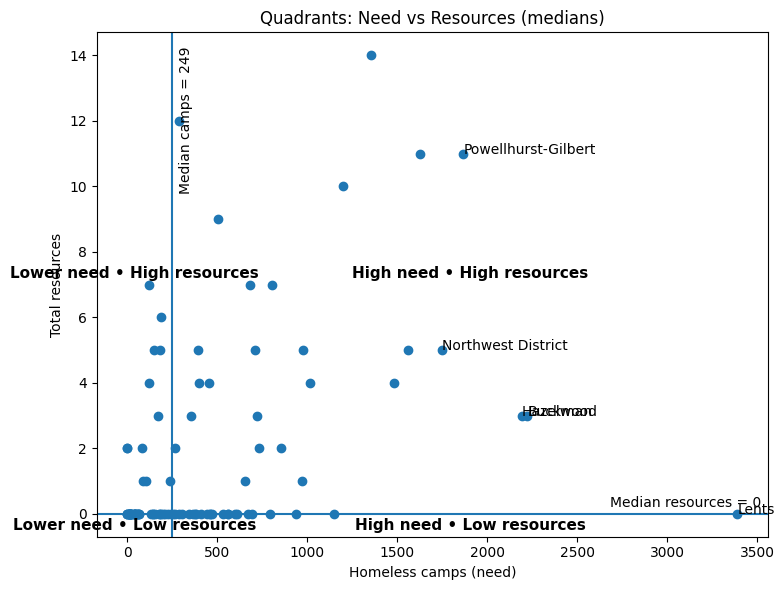

In [25]:
print("adding some additional labels for clarity")

# Medians
med_camps = df["homeless_camps"].median()
med_resources = df["final_resource_calc"].median()

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter
ax.scatter(df["homeless_camps"], df["final_resource_calc"])

# Median lines
ax.axvline(med_camps)
ax.axhline(med_resources)

# Titles/axes
ax.set_title("Quadrants: Need vs Resources (medians)")
ax.set_xlabel("Homeless camps (need)")
ax.set_ylabel("Total resources")

# Get limits (after plotting) to position labels nicely
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()

# Midpoints for each quadrant
x_left  = (x0 + med_camps) / 2
x_right = (med_camps + x1) / 2
y_low   = (y0 + med_resources) / 2
y_high  = (med_resources + y1) / 2

# Quadrant labels
ax.text(x_right, y_high, "High need • High resources", ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_left,  y_high, "Lower need • High resources", ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_right, y_low,  "High need • Low resources",  ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_left,  y_low,  "Lower need • Low resources", ha="center", va="center", fontsize=11, fontweight="bold")

# Annotate median lines with values
ax.annotate(f"Median camps = {med_camps:.0f}",
            xy=(med_camps, y1), xytext=(5, -10),
            textcoords="offset points", va="top", rotation=90)

ax.annotate(f"Median resources = {med_resources:.0f}",
            xy=(x1, med_resources), xytext=(-5, 5),
            textcoords="offset points", ha="right")

#
# Optional labels for extreme points
top = df.nlargest(5, "homeless_camps")
for _, r_ in top.iterrows():
    plt.text(r_["homeless_camps"], r_["final_resource_calc"], r_["neighborhood"])
#
plt.tight_layout()
plt.show()


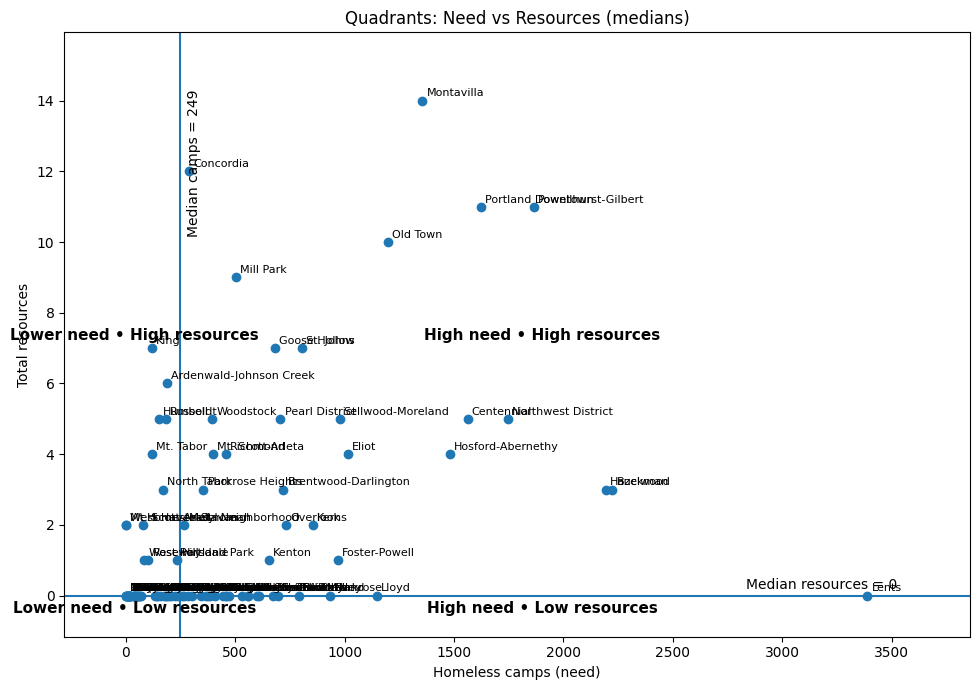

In [28]:
# If df already exists, start here:
df = df.copy()
df.columns = df.columns.str.strip()

# Ensure required columns and numeric types
req = ["neighborhood", "homeless_camps", "final_resource_calc", "number_of_locations"]
missing = set(req) - set(df.columns)
if missing:
    raise KeyError(f"Missing columns: {missing}")

df["neighborhood"] = df["neighborhood"].astype("string").str.strip()
num_cols = ["homeless_camps", "final_resource_calc", "number_of_locations"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

# Compute medians
med_camps = df["homeless_camps"].median()
med_resources = df["final_resource_calc"].median()

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(df["homeless_camps"], df["final_resource_calc"])

# Median lines
ax.axvline(med_camps)
ax.axhline(med_resources)

# Titles/axes
ax.set_title("Quadrants: Need vs Resources (medians)")
ax.set_xlabel("Homeless camps (need)")
ax.set_ylabel("Total resources")

# After plotting, get limits and pad a bit so labels don't clip
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
xr = x1 - x0
yr = y1 - y0
ax.set_xlim(x0 - 0.03 * xr, x1 + 0.08 * xr)
ax.set_ylim(y0 - 0.03 * yr, y1 + 0.08 * yr)

# Quadrant label positions (center of each quadrant)
x_left  = (x0 + med_camps) / 2
x_right = (med_camps + x1) / 2
y_low   = (y0 + med_resources) / 2
y_high  = (med_resources + y1) / 2

ax.text(x_right, y_high, "High need • High resources", ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_left,  y_high, "Lower need • High resources", ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_right, y_low,  "High need • Low resources",  ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(x_left,  y_low,  "Lower need • Low resources", ha="center", va="center", fontsize=11, fontweight="bold")

# Annotate median lines with values
ax.annotate(f"Median camps = {med_camps:.0f}",
            xy=(med_camps, y1), xytext=(5, -10),
            textcoords="offset points", va="top", rotation=90)
ax.annotate(f"Median resources = {med_resources:.0f}",
            xy=(x1, med_resources), xytext=(-5, 5),
            textcoords="offset points", ha="right")

# --- Label every neighborhood (small offset so text isn’t on top of the dot) ---
for x, y, lab in zip(df["homeless_camps"], df["final_resource_calc"], df["neighborhood"].astype(str)):
    ax.annotate(lab, (x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

plt.tight_layout()
plt.show()